<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
#!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
from freeze_graph import freeze_graph
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#FEATURES AND LABELS  


with open('/content/features_withITO (2).bin','rb') as file:
  temp = pickle.load(file)
  
  
with open('/content/labels_withITO (2).bin','rb') as file:
  l = pickle.load(file)

In [0]:


features =[]
for i in temp:
  features.append(list(i))

labels=[]  
for i in l:
  labels.append(list(i))

In [5]:
print(np.shape(features))

(2376, 9)


In [32]:
print(np.shape(labels))

(2376, 1)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
## 56 BIT (2253,3147)

# features = joblib.load('/content/features56.pkl')
# labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

# features = joblib.load('/content/features64.pkl')
# labels = joblib.load('/content/labels64.pkl')


In [0]:
# # 32 BIT (2253,1035)

# features = joblib.load('/content/features32.pkl')
# labels = joblib.load('/content/labels32.pkl')

In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [55]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17804099232297452624
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 568024926967224581
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17937843173293588288
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17325784032477648017
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:

# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.models import Sequential
# from keras.optimizers import Adam
# model = Sequential()
# model.add(Dense(9, input_shape = (9, ), activation = 'relu') )
# # model.add(Dense(15, activation = 'relu') )
# # \
# model.add(BatchNormalization(axis = -1))
# model.add(Dropout(0.5))
# model.add(Dense(1,  activation = 'relu'))

In [0]:
# model.compile(optimizer = Adam(lr = 0.001), loss = 'mse')
# model.summary()

In [0]:
# hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 300, verbose = 1, batch_size = 32, shuffle = True)

In [0]:
# tr = hist.history['loss']
# val_ls = hist.history['val_loss']
# plt.plot(tr[1:])
# plt.plot(val_ls[1:])

In [0]:
# predicted = model.predict([x_test_t])


In [0]:
# print(np.shape(y_test_t))
# # print(np.shape(predicted))

# actual =[]
# pred=[]
# se=0
# show = np.hstack((y_test_t, predicted))

# for i in show:
#   se+=(i[0]-i[1])**2
#   actual.append(i[0])
#   pred.append(i[1])
  
 




In [43]:
# print(np.shape(y_test_t))
# rmse = (se/676)**0.5


(713, 1)


In [19]:
# print(rmse)

21.314487027119245


In [0]:
# plt.plot(actual)
# plt.plot(pred)



In [51]:
print(np.shape(labels))

(2376, 1)


In [0]:
x = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((9, 15)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,15)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((15,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl_batch = tf.compat.v1.layers.batch_normalization(hidl)
outl = tf.add(tf.matmul(outl_batch,wo),bo,name = 'output')


In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.4*tf.reduce_max(tf.subtract(y,outl))

opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

  

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

3441.3435	2738.482
3223.377	2422.0256
2503.3179	3772.265
2027.5503	3919.097
4152.1626	2787.7083
3233.0828	2791.2063
2820.7695	3970.8154
2449.3918	3069.7893
3094.2622	2925.6445
2008.9719	2244.8408
3013.8333	2870.1807
3451.1072	3537.3198
3427.7236	4707.9365
3161.2817	3577.9941
4147.221	2179.2202
5030.9077	2177.8528
2117.3848	2645.7998
2589.9482	4907.413
2859.0903	3619.6423
4441.35	3696.4373
2085.274	3332.0835
3111.2234	3276.1865
3019.578	3586.3352
4425.507	2365.524
2518.7273	2644.0295
3847.1826	3742.11
3296.3223	4547.4634
5339.1074	2995.8184
3415.8076	3805.9832
2626.4075	1909.3098
2836.5093	3364.1177
2477.9475	2584.581
4937.0786	2083.7078
4095.3198	2266.164
5984.1104	2879.5576
2563.6873	2770.309
2283.391	2937.521
2804.8735	2086.7988
2098.96	2785.4717
2721.1282	3315.4617
4389.702	2424.364
2821.5986	2092.233
2037.5935	2926.163
3534.6821	3419.931
2109.627	3056.156
2260.508	3068.3335
2993.9739	3491.5393
3066.4094	3112.4133
1979.9075	2188.5256
4752.0757	3119.27
4225.11	4434.7163
2642.944	2490

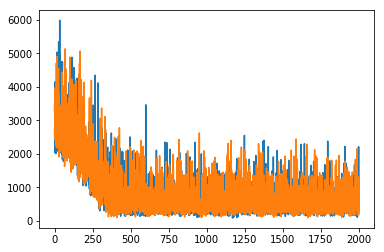

In [78]:
train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,2000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    
#     model = simple_save(sess,'/content/drive/My Drive/Custom_Models__withITO',inputs = {'input' : x}, outputs = {'output': outl})
#     print('Saved model!')
    
 

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64updhidden.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

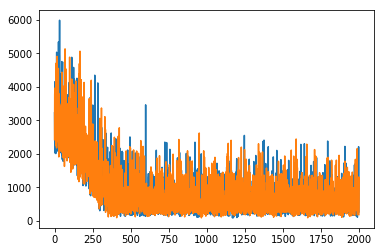

In [80]:
plt.plot(train[1:])
plt.plot(val[1:])

In [81]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(9, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(15, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(9, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(15, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/gamma:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/beta:0' shape=(15,) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''